# Simple Text Classification 
In this notebook, we attempt to separate reports that indicate presence of cancer from those without cancer using non-LLM methods.

In [1]:
import os
import pandas as pd
import regex as re
import spacy
import matplotlib.pyplot as plt

from datasets import Dataset 
from hydra import compose, initialize
from omegaconf import OmegaConf, DictConfig
from collections import defaultdict, Counter

from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    balanced_accuracy_score, 
    roc_auc_score, 
    classification_report,
    f1_score
)

pd.options.mode.chained_assignment = None 

with initialize(version_base=None, config_path="../conf", job_name="test"):
        cfg = compose(config_name="config")
        print(OmegaConf.to_yaml(cfg))

/users/robinpark/miniconda3/envs/llama/lib/python3.9/site-packages/torch/onnx/_internal/_beartype.py:30: UserWarning: unhashable type: 'list'
  warnings.warn(f"{e}")
/users/robinpark/miniconda3/envs/llama/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


random_seed: 0
work_dir: /work/robinpark
root_dir: ${work_dir}/NCIMIPreprocessing
raw_dicom_folder: ${work_dir}/data-apr23/PID010A
clean_path: ${work_dir}/PID010A_clean
unpaired_reports: /work/rhydian/ProcessedSpinalMRIReports/
patient_metadata: ${clean_path}/patient_metadata.csv
train_labeled_data: ${clean_path}/train_manually_labeled_set.csv
llm_results_path: /work/robinpark/PID010A_clean/llm_results
model_weights_save_path: /scratch/shared/beegfs/robinpark
gpt_model: gpt-4
adapter_base: meta-llama/Llama-2-7b-chat-hf
adapter_model: ${model_weights_save_path}/gpt4-fine-tuned-llama2-7b
labeled_data: ${clean_path}/segmented_test_manually_labeled_set.csv
llama_tokenizer: hf-internal-testing/llama-tokenizer
prompt_cue: evidence
llama_model: HuggingFaceH4/zephyr-7b-beta



## Word Frequency in Hand-Labeled Data
We compare words that occur most frequently in hand-labeled data (cancer vs no cancer reports).

In [2]:
def part_of_speech(doc, pos_tag, overlap_words):
    # adverb tokens that arent stop words or punctuations
    pos = [token.text.lower()
            for token in doc
            if (not token.is_stop and
                not token.is_punct and
                token.pos_ == pos_tag)]
    pos = [i for i in pos if i not in overlap_words]
    return pos

def freq_count(li_words, num_words=10):
    word_freq = Counter(li_words)
    common_words = word_freq.most_common(num_words)
    return common_words

def get_overlap(cancer_words, nc_words):
    overlap_words = [w for w,_ in cancer_words for i,_ in nc_words if w==i]
    return overlap_words

def create_counts(nlp, post, overlap_words=[]):
    doc = nlp(post)
    # all tokens that arent stop words or punctuations
    words = [token.text.lower()
            for token in doc
            if not token.is_stop and
               not token.is_punct and
               not token.is_space]
    words = [i for i in words if i not in overlap_words]

    # tokens that arent stop words or punctuations by POS
    nouns = part_of_speech(doc, "NOUN", overlap_words)
    adjs = part_of_speech(doc, "ADJ", overlap_words)
    advs = part_of_speech(doc, "ADV", overlap_words)
    verbs = part_of_speech(doc, "VERB", overlap_words)

    common_words = freq_count(words)
    common_nouns = freq_count(nouns)
    common_adjs = freq_count(adjs)
    common_advs = freq_count(advs)
    common_verbs = freq_count(verbs)

    print(f'Common words: {common_words}')
    print(f'Common nouns: {common_nouns}')
    print(f'Common verbs: {common_verbs}')
    print(f'Common adjectives: {common_adjs}')
    print(f'Common adverbs: {common_advs}')

    return common_words, common_nouns, common_verbs, common_adjs, common_advs

def words_by_report(nlp, report):
   doc = nlp(report)
   words = [token.text.lower()
            for token in doc
            if not token.is_stop and
               not token.is_punct and
               not token.is_space]
   return words

def count_word(word, df_in):
    df_in['mention_flag'] = df_in['report_text'].str.contains(word)
    print(df_in['mention_flag'].sum())
    return df_in.loc[df_in['mention_flag']==True]

def show_results(df_cancer, df_nc):
    mrg = pd.concat([df_cancer,df_nc]).reset_index(drop=True)
    mrg.loc[mrg.results_cancer.isna(), 'results_cancer'] = 0

    labels = mrg['spine_cancer'].astype(int)
    pred = mrg['results_cancer'].astype(int)

    class_report = classification_report(labels, pred, target_names=['no_cancer','cancer'])
    balanced_acc = balanced_accuracy_score(labels, pred)
    roc_auc = balanced_accuracy_score(labels, pred)
    conf_mat = confusion_matrix(labels, pred)
    f1 = f1_score(labels, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                                    display_labels=['No Cancer', 'Cancer'])

    print(f'Balanced accuracy: {balanced_acc}')
    print(f'ROC AUC score: {roc_auc}')
    print(f'F1 score: {f1}')
    print(class_report)
    disp.plot(cmap=plt.cm.Blues)
    return mrg

def flag_words(df_cancer, df_nc, word, flag, exception=[]):
    if exception != []:
        df_cancer[flag] = df_cancer['words'].apply(lambda x: any(word in w for w in x if w not in exception))
        df_nc[flag] = df_nc['words'].apply(lambda x: any(word in w for w in x if w not in exception))
    else:
        df_cancer[flag] = df_cancer['words'].apply(lambda x: any(word in w for w in x))
        df_nc[flag] = df_nc['words'].apply(lambda x: any(word in w for w in x))

def flag_phrase(df_cancer, df_nc, phrase, flag):
    df_cancer.loc[df_cancer['report_text'].str.lower().str.find(phrase) > -1, flag] = True
    df_cancer.loc[df_cancer[flag].isna(), flag] = False
    df_nc.loc[df_nc['report_text'].str.lower().str.find(phrase) > -1, flag] = True
    df_nc.loc[df_nc[flag].isna(), flag] = False

def formatting_func(example):
    if example['flag_cancer'] == 1:
        output = 'Based on the report, the patient has cancer (%).'
    else:
        output = 'Based on the report, the patient does not have cancer ($).'
    example['input_output'] = f"""\
        ### Question: Does the patient have metastatic spinal cancer, affecting the bones, marrow or spinal cord?

                Output ONLY ONE value according to these rules:

                1. If spinal cancer is not present, you must assign a value of '$'.
                2. If spinal cancer is present, you must assign a value of '%'.
                
            Let's think step by step.
        
        ### Report: {example['report_text']}\n 
        
        ### Answer: {output}"""
        
    return example['input_output']

In [3]:
# Import hand-labeled data
df_train_labeled = pd.read_csv(cfg.train_labeled_data, index_col=0)

In [4]:
# Separate cancer with no cancer
df_train_cancer = df_train_labeled.loc[df_train_labeled.spine_cancer == 1].reset_index(drop=True)
df_train_nc = df_train_labeled.loc[df_train_labeled.spine_cancer == 0].reset_index(drop=True)

# Append reports of each kind
cancer_reports = df_train_cancer['report_text'].str.cat(sep=', ')
no_cancer_reports = df_train_nc['report_text'].str.cat(sep=', ')

In [5]:
# Initialise spacy model
nlp = spacy.load("en_core_web_sm")

In [6]:
print('-----Common words in cancer reports-----')
cancer_words, cancer_nouns, cancer_verbs, cancer_adjs, cancer_advs = create_counts(nlp, cancer_reports)
print('\n')
print('-----Common words in no cancer reports-----')
nc_words, nc_nouns, nc_verbs, nc_adjs, nc_advs = create_counts(nlp, no_cancer_reports)

-----Common words in cancer reports-----
Common words: [('spine', 402), ('cord', 320), ('vertebral', 280), ('spinal', 218), ('compression', 206), ('mri', 203), ('metastatic', 181), ('canal', 179), ('left', 178), ('signal', 164)]
Common nouns: [('cord', 294), ('spine', 282), ('compression', 198), ('canal', 177), ('signal', 156), ('body', 154), ('disc', 150), ('disease', 149), ('evidence', 133), ('level', 108)]
Common verbs: [('noted', 88), ('seen', 68), ('demonstrated', 56), ('left', 51), ('compared', 38), ('associated', 36), ('known', 32), ('keeping', 29), ('involving', 29), ('visualised', 25)]
Common adjectives: [('vertebral', 280), ('spinal', 186), ('metastatic', 156), ('cervical', 138), ('normal', 118), ('posterior', 116), ('degenerative', 113), ('previous', 110), ('left', 103), ('significant', 94)]
Common adverbs: [('likely', 21), ('bilaterally', 18), ('right', 18), ('previously', 17), ('particularly', 15), ('significantly', 14), ('currently', 13), ('anteriorly', 12), ('broad', 12)

In [7]:
# Collate words that overlap across classes to remove them from frequency calculation
overlap_words = get_overlap(cancer_words, nc_words)
overlap_nouns = get_overlap(cancer_nouns, nc_nouns)
overlap_adjs = get_overlap(cancer_adjs, nc_adjs)
overlap_advs = get_overlap(cancer_advs, nc_adjs)
overlap_verbs = get_overlap(cancer_verbs, nc_verbs)
all_overlaps = overlap_words + overlap_nouns + overlap_adjs + overlap_advs + overlap_verbs

In [8]:
print('-----Common words in cancer reports (excluding overlaps)-----')
cancer_words, cancer_nouns, cancer_verbs, cancer_adjs, cancer_advs = create_counts(nlp, cancer_reports, all_overlaps)
print('\n')
print('-----Common words in no cancer reports (excluding overlaps)-----')
nc_words, nc_nouns, nc_verbs, nc_adjs, nc_advs = create_counts(nlp, no_cancer_reports, all_overlaps)

-----Common words in cancer reports (excluding overlaps)-----
Common words: [('metastatic', 181), ('canal', 179), ('body', 156), ('disease', 152), ('evidence', 133), ('lumbar', 131), ('posterior', 123), ('nerve', 112), ('level', 110), ('changes', 106)]
Common nouns: [('canal', 177), ('body', 154), ('disease', 149), ('evidence', 133), ('level', 108), ('pain', 105), ('changes', 103), ('nerve', 94), ('marrow', 93), ('thoracic', 91)]
Common verbs: [('compared', 38), ('associated', 36), ('known', 32), ('keeping', 29), ('involving', 29), ('worsening', 25), ('appear', 25), ('described', 24), ('causing', 24), ('extending', 24)]
Common adjectives: [('metastatic', 156), ('posterior', 116), ('foraminal', 81), ('mild', 77), ('new', 74), ('lower', 68), ('axial', 66), ('multiple', 63), ('central', 62), ('soft', 52)]
Common adverbs: [('likely', 21), ('bilaterally', 18), ('previously', 17), ('particularly', 15), ('significantly', 14), ('currently', 13), ('anteriorly', 12), ('broad', 12), ('posteriorly

In [9]:
df_train_cancer['words'] = df_train_cancer['report_text'].apply(lambda x: words_by_report(nlp, x))
df_train_nc['words'] = df_train_nc['report_text'].apply(lambda x: words_by_report(nlp, x))

In [10]:
flag_words(df_train_cancer, df_train_nc, 'cancer', 'cancer')
flag_words(df_train_cancer, df_train_nc, 'heterogeneous', 'hetgen')
flag_words(df_train_cancer, df_train_nc, 'oma', 'oma', 
           exception=['haemangioma','haemangiomas','lipoma',
                      'myelomalacia','myelomalacic','anomaly'])

flag_phrase(df_train_cancer, df_train_nc, 'metasta', 'met')
flag_phrase(df_train_cancer, df_train_nc, 'no metasta', 'no_met')
flag_phrase(df_train_cancer, df_train_nc, 'no evidence of metasta', 'no_evi_met')

In [11]:
print('--REPORTS WITH CANCER--')
for flag in ['cancer', 'hetgen', 'oma', 'met', 'no_met', 'no_evi_met']: 
    cancer_count = df_train_cancer[flag].loc[df_train_cancer[flag] == True].count()
    print(flag + ': ' + cancer_count.astype(str))

--REPORTS WITH CANCER--
cancer: 37
hetgen: 8
oma: 57
met: 101
no_met: 3
no_evi_met: 6


In [12]:
print('--REPORTS WITHOUT CANCER--')
for flag in ['cancer', 'hetgen', 'oma', 'met', 'no_met', 'no_evi_met']: 
    nc_count = df_train_nc[flag].loc[df_train_nc[flag] == True].count()
    print(flag + ': ' + nc_count.astype(str))

--REPORTS WITHOUT CANCER--
cancer: 5
hetgen: 3
oma: 10
met: 10
no_met: 2
no_evi_met: 5


In [13]:
df_train_cancer.loc[
    ((df_train_cancer.met == True) | (df_train_cancer.oma == True)) & 
    ((df_train_cancer.no_evi_met == False) & (df_train_cancer.no_met == False)),
    'results_cancer'
] = 1

In [14]:
df_train_nc.loc[
    ((df_train_nc.met == True) | (df_train_nc.oma == True)) & 
    ((df_train_nc.no_evi_met == False) & (df_train_nc.no_met == False)),
    'results_cancer'
] = 1

Balanced accuracy: 0.8911764705882352
ROC AUC score: 0.8911764705882352
F1 score: 0.9152542372881356
              precision    recall  f1-score   support

   no_cancer       0.83      0.88      0.86        85
      cancer       0.93      0.90      0.92       150

    accuracy                           0.89       235
   macro avg       0.88      0.89      0.89       235
weighted avg       0.90      0.89      0.89       235



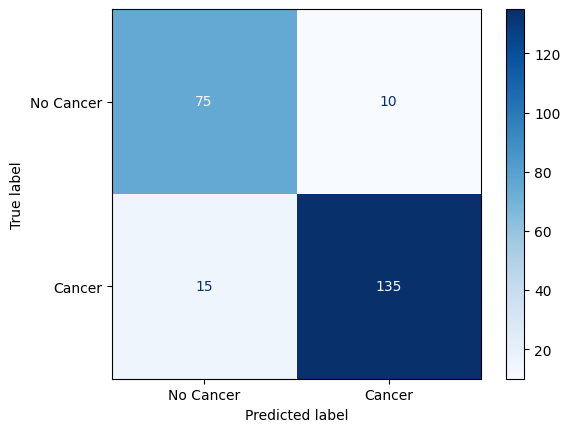

In [15]:
df_train_regex = show_results(df_train_cancer, df_train_nc)

In [16]:
df_train_labeled.spine_cancer.value_counts()

1    150
0     85
Name: spine_cancer, dtype: int64

## Attempt on Test Set

In [25]:
df_test = pd.read_csv(cfg.labeled_data, index_col=0)

In [26]:
df_test.spine_cancer.value_counts()

1    256
0    157
Name: spine_cancer, dtype: int64

In [28]:
df_test_cancer = df_test.loc[df_test.spine_cancer==1]
df_test_nc = df_test.loc[df_test.spine_cancer==0]

df_test_cancer['words'] = df_test_cancer['report_text'].apply(lambda x: words_by_report(nlp, x))
df_test_nc['words'] = df_test_nc['report_text'].apply(lambda x: words_by_report(nlp, x))

In [29]:
flag_words(df_test_cancer, df_test_nc, 'cancer', 'cancer')
flag_words(df_test_cancer, df_test_nc, 'heterogeneous', 'hetgen')
flag_words(df_test_cancer, df_test_nc, 'oma', 'oma', exception=['haemangioma','haemangiomas'])

flag_phrase(df_test_cancer, df_test_nc, 'metasta', 'met')
flag_phrase(df_test_cancer, df_test_nc, 'no metasta', 'no_met')
flag_phrase(df_test_cancer, df_test_nc, 'no evidence of metasta', 'no_evi_met')

In [30]:
df_test_cancer.loc[
    ((df_test_cancer.met == True) | (df_test_cancer.oma == True)) & 
    ((df_test_cancer.no_evi_met == False) & (df_test_cancer.no_met == False)),
    'results_cancer'
] = 1

In [31]:
df_test_nc.loc[
    ((df_test_nc.met == True) | (df_test_nc.oma == True)) & 
    ((df_test_nc.no_evi_met == False) & (df_test_nc.no_met == False)),
    'results_cancer'
] = 1

Balanced accuracy: 0.8379652667197452
ROC AUC score: 0.8379652667197452
F1 score: 0.888468809073724
              precision    recall  f1-score   support

   no_cancer       0.85      0.76      0.80       157
      cancer       0.86      0.92      0.89       256

    accuracy                           0.86       413
   macro avg       0.86      0.84      0.84       413
weighted avg       0.86      0.86      0.86       413



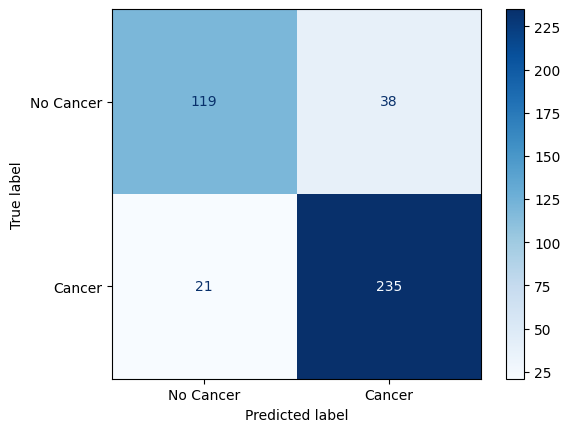

In [32]:
df_test_regex = show_results(df_test_cancer, df_test_nc)

## Apply Separation to Unpaired Reports
Create a larger training set for prompt tuning, using unpaired reports without images.

In [ ]:
up_reports_train = pd.read_csv(cfg.unpaired_reports + 'unpaired_reports_train.csv', index_col=0)
up_reports_val = pd.read_csv(cfg.unpaired_reports + 'unpaired_reports_val.csv', index_col=0)
up_reports_test = pd.read_csv(cfg.unpaired_reports + 'unpaired_reports_test.csv', index_col=0)

In [ ]:
up_reports = pd.concat([up_reports_train, up_reports_val, up_reports_test]).reset_index(drop=True)

In [ ]:
up_reports['words'] = up_reports['Report text'].apply(lambda x: words_by_report(nlp, x))

In [ ]:
up_reports = up_reports.rename(columns={'Report text':'report_text'})

In [ ]:
flag_words(up_reports, up_reports, 'cancer', 'cancer')
flag_words(up_reports, up_reports, 'heterogeneous', 'hetgen')
flag_words(up_reports, up_reports, 'oma', 'oma', exception=['haemangioma','haemangiomas'])

flag_phrase(up_reports, up_reports, 'metasta', 'met')
flag_phrase(up_reports, up_reports, 'no metasta', 'no_met')
flag_phrase(up_reports, up_reports, 'no evidence of metasta', 'no_evi_met')

In [ ]:
up_reports.loc[
    (((up_reports.met == True) | (up_reports.oma == True)) & 
    ((up_reports.no_evi_met == False) & (up_reports.no_met == False))),
    'flag_cancer'
] = 1

In [ ]:
up_reports.loc[up_reports.flag_cancer.isna(), 'flag_cancer'] = 0

In [ ]:
up_reports.flag_cancer.value_counts()

In [ ]:
up_reports.to_csv(cfg.clean_path + '/unpaired_reports_flagged.csv')

In [ ]:
up_reports = pd.read_csv(cfg.clean_path + '/unpaired_reports_flagged.csv', index_col=0)

In [ ]:
full_unpaired = up_reports[['report_text','flag_cancer']]

In [ ]:
unpaired_cancer = full_unpaired[full_unpaired['flag_cancer']==1]
unpaired_nc = (full_unpaired[full_unpaired['flag_cancer']==0]).sample(len(unpaired_cancer),random_state=1)

In [ ]:
unpaired_balanced = pd.concat([unpaired_cancer,unpaired_nc]).reset_index(drop=True)
unpaired_balanced['input_output'] = unpaired_balanced.apply(lambda x: formatting_func(x), axis=1)
unpaired_balanced_train, unpaired_balanced_test = train_test_split(unpaired_balanced, test_size=500, random_state=1, 
                                                                   stratify=unpaired_balanced['flag_cancer'])

# For a larger test set
# unpaired_balanced_train, unpaired_balanced_test = train_test_split(unpaired_balanced, test_size=0.3, random_state=1, 
#                                                                    stratify=unpaired_balanced['flag_cancer'])

In [ ]:
print(len(unpaired_balanced_train))
print(len(unpaired_balanced_test))

44244
500


In [ ]:
dataset_train = Dataset.from_pandas(unpaired_balanced_train[['input_output']].reset_index(drop=True))
dataset_test = Dataset.from_pandas(unpaired_balanced_test[['input_output']].reset_index(drop=True))

In [ ]:
dataset_train.to_json(os.path.join(cfg.clean_path,"unpaired_bal_train2.json"))
dataset_test.to_json(os.path.join(cfg.clean_path,"unpaired_bal_test2.json"))

# Versions with larger test set (30%)
# dataset_train.to_json(os.path.join(cfg.clean_path,"unpaired_bal_train.json"))
# dataset_test.to_json(os.path.join(cfg.clean_path,"unpaired_bal_test.json"))

Creating json from Arrow format:   0%|          | 0/45 [00:00<?, ?ba/s]

Creating json from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 78.65ba/s]


777155

## Chexpert Mention Classification

In [ ]:
from nltk.tokenize import sent_tokenize
import nltk 

nltk.download('punkt')

[nltk_data] Downloading package punkt to /users/robinpark/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
df_train_cancer['sents'] = df_train_cancer['report_text'].apply(lambda x: sent_tokenize(x))
df_train_nc['sents'] = df_train_nc['report_text'].apply(lambda x: sent_tokenize(x))

In [ ]:
from bllipparser import RerankingParser

rrp = RerankingParser.fetch_and_load('GENIA+PubMed', verbose=True)

Model directory: /users/robinpark/.local/share/bllipparser/GENIA+PubMed
Model directory already exists, not reinstalling


In [ ]:
def parse_bllip(li_sents):
    li_parsed = []
    for i in li_sents:
        # Exclude punctuation and single character sentences
        if len(i) > 1:
            li_parsed.append(rrp.simple_parse(i))
    return li_parsed

In [ ]:
df_train_cancer['parsed_sents'] = df_train_cancer['sents'].apply(lambda x: parse_bllip(x))

In [ ]:
df_train_nc['parsed_sents'] = df_train_nc['sents'].apply(lambda x: parse_bllip(x))

### Chexpert Results

In [ ]:
# Create Chexpert set to run
df_train_labeled['report_text'] = df_train_labeled['report_text'].apply(lambda x: f'"{x}"')
df_train_labeled[['report_text']].to_csv("/work/robinpark/PID010A_clean/train_chexpert_input.csv", header=False, index=False)

df_test['report_text'] = df_test['report_text'].apply(lambda x: f'"{x}"')
df_test[['report_text']].to_csv("/work/robinpark/PID010A_clean/test_chexpert_input.csv", header=False, index=False)

In [ ]:
def chexpert_results_prep(train=True):
    if train:
        flag = 'train'
        df_labels = df_train_labeled
    else:
        flag = 'test'
        df_labels = df_test
    df_chexpert = pd.read_csv(f'/work/robinpark/PID010A_clean/llm_results/chexpert_{flag}_results.csv')
    df_chexpert_mrg = df_labels[['report_text','spine_cancer']]
    df_mrg = df_chexpert.merge(df_chexpert_mrg, left_index=True, right_index=True, how='left').rename(columns={'Cancer':'results_cancer'})
    df_mrg.loc[(df_mrg.results_cancer.isna()) | (df_mrg.results_cancer < 0), 'results_cancer'] = 0
    return df_mrg

In [ ]:
def summ_results(mrg):    

    labels = mrg['spine_cancer'].astype(int)
    pred = mrg['results_cancer'].astype(int)

    class_report = classification_report(labels, pred, target_names=['no_cancer','cancer'])
    balanced_acc = balanced_accuracy_score(labels, pred)
    roc_auc = balanced_accuracy_score(labels, pred)
    conf_mat = confusion_matrix(labels, pred)
    f1 = f1_score(labels, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                                  display_labels=['No Cancer', 'Cancer'])
    
    print(f'\n----RESULTS FOR CHEXPERT -----\n')
    print(f'Balanced accuracy: {balanced_acc}')
    print(f'ROC AUC score: {roc_auc}')
    print(f'F1 score: {f1}')
    print(class_report)
    disp.plot(cmap=plt.cm.Blues)

    return mrg


----RESULTS FOR CHEXPERT -----

Balanced accuracy: 0.8370588235294117
ROC AUC score: 0.8370588235294117
F1 score: 0.9102167182662539
              precision    recall  f1-score   support

   no_cancer       0.95      0.69      0.80        85
      cancer       0.85      0.98      0.91       150

    accuracy                           0.88       235
   macro avg       0.90      0.84      0.86       235
weighted avg       0.89      0.88      0.87       235



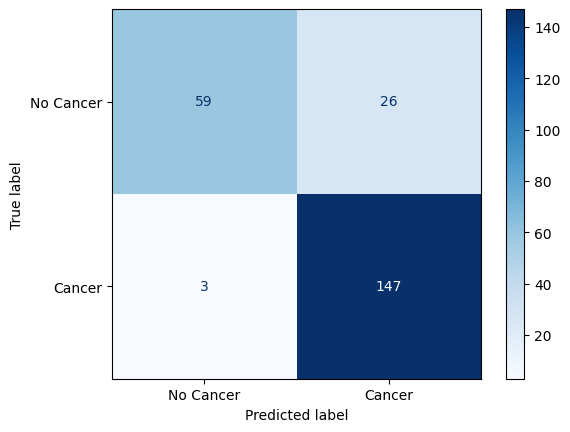

In [ ]:
df_mrg_train = chexpert_results_prep(train=True)
df_chexpert_train = summ_results(df_mrg_train)


----RESULTS FOR CHEXPERT -----

Balanced accuracy: 0.7945768180689998
ROC AUC score: 0.7945768180689998
F1 score: 0.8706739526411658
              precision    recall  f1-score   support

   no_cancer       0.87      0.65      0.74       158
      cancer       0.81      0.94      0.87       255

    accuracy                           0.83       413
   macro avg       0.84      0.79      0.81       413
weighted avg       0.83      0.83      0.82       413



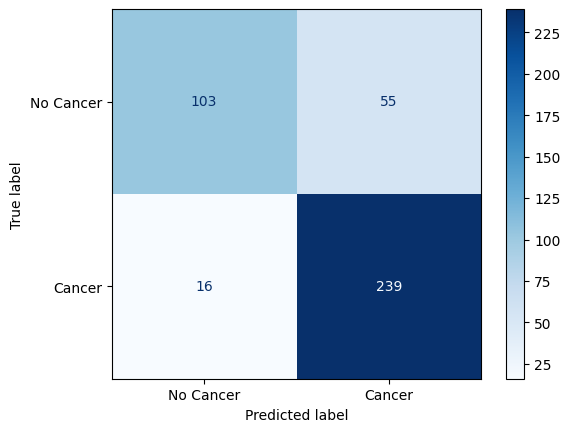

In [ ]:
df_mrg_test = chexpert_results_prep(train=False)
df_chexpert_test = summ_results(df_mrg_test)